# Model

In [1]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("black")
        else:
            node_colors.append("silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

# Graph

In [2]:
def create_data(n):
    
    k = 0.5
    
    #G = nx.triangular_lattice_graph(n,n)
    G = nx.grid_2d_graph(n,n)
    #G = nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

# Simulated Annealing

In [3]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

def Plot2D(G):

    pos =nx.get_node_attributes(G,'pos')
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    fig, ax = plt.subplots(figsize=(2,2))
    nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Testing 

## Create 100 Initial Graphs with target Delta

In [6]:
def Create_Initial_Graphs(repeat_num,N,delta = 0):

    Gs = []
    d_target = delta
    
    for i in tqdm(range(repeat_num)):

        G0 = create_data(N)
        edge = len(G0.copy().edges())
        H = G0.copy() 

        while (calculate_delta(H) != d_target):

            H = simulated_annealing(G0.copy(),target=d_target)

        Gs.append(H.copy())
        
    return Gs

In [7]:
def Quench_Process(Gs):

    total=[]
    for i in tqdm(range(100)):
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            
            fr = frustration_count(H)
            res.append(fr)

        total.append(res)     
        
    return np.array(total)

In [8]:
def Get_Probabilites(data,Edge,repeat):

    p_t=[]
    for t in range(len(data[0])):

        #print(means[:,t])

        prob=[]
        for i in range(0,Edge):
            prob.append(np.count_nonzero(np.array(data[:,t]) == i))
        p_t.append(np.array(prob)/100)

    P_t = np.array(p_t)

    p_even=[]
    for l in P_t:
        p_even.append(l[::2])

    P_even = np.array(p_even)

    return P_t,P_even

In [12]:
def Get_Means(data):
    
    total = np.array(data)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))

    return np.array(final)

In [9]:
repeat_num = 100
N = 10

Gs = Create_Initial_Graphs(repeat_num,N,0)

100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


In [10]:
Edge = len(Gs[0].copy().edges())

print(Edge)

180


In [11]:
data = Quench_Process(Gs)

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


In [13]:
P_t,P_even = Get_Probabilites(data,Edge,repeat_num)

Means  = Get_Means(data)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Plot Results

In [60]:
#https://stackoverflow.com/questions/64113201/how-to-make-class-for-onclickevent-functions-for-interactive-plot-in-matplotli

<IPython.core.display.Javascript object>


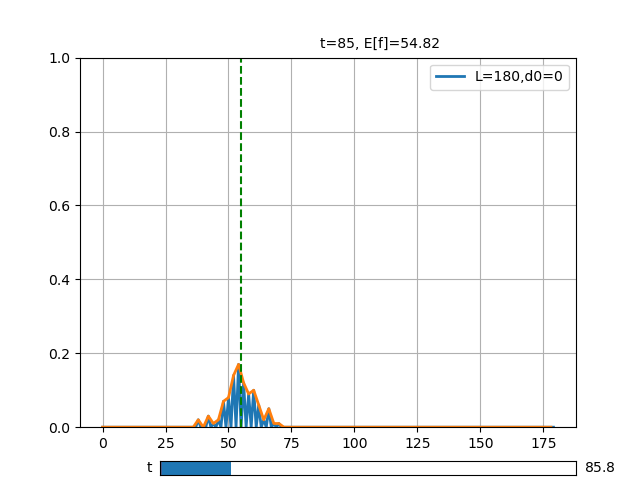

In [14]:
#https://stackoverflow.com/questions/7153969/matplotlib-slider-redraw-does-not-update-figtext

data1 = P_t
data2 = P_even
data3 = Means

import numpy as np
import pylab as p
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
p.grid()
ax.set_ylim(0,1)
#x = np.arange(0,500,1)
#f = np.sin(x/100.0)
#l11, = p.plot(f)

t = 0
l11, = p.plot([i for i in range(len(data1[t]))], data1[t], lw=2,label ="L=180,d0=0")
l12, = p.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
#l2, = p.scatter(Final[t,0],0.5, lw=2)

line = p.axvline(x=data3[t,0],linestyle="--",color="green")
ax.legend(loc="upper right")
#ax = p.axes([0.25, 0.05, 0.7, 0.03])#, axisbg='lightgoldenrodyellow')


ax = p.axes([0.25, 0.01, 0.65, 0.03])
slider1 = Slider(ax, 't', 0, 500, valinit=0)

# the text on the figure
fig_text = p.figtext(0.5, 0.9,  str(slider1.val))

def F(t,array):
    return array[t]

def update(val):

    value = int(slider1.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])

    fig_text.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))

    p.draw()

slider1.on_changed(update)
plt.show()

<IPython.core.display.Javascript object>


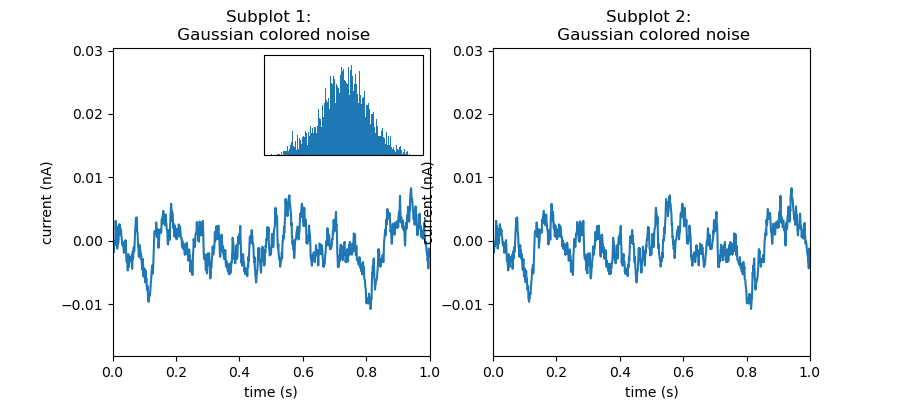

In [30]:
# https://matplotlib.org/2.0.2/examples/pylab_examples/axes_demo.html

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# create some data to use for the plot
dt = 0.001
t = np.arange(0.0, 10.0, dt)
r = np.exp(-t[:1000]/0.05)               # impulse response
x = np.random.randn(len(t))
s = np.convolve(x, r)[:len(x)]*dt  # colored noise

fig = plt.figure(figsize=(9, 4),facecolor='white')
ax = fig.add_subplot(121)
# the main axes is subplot(111) by default
plt.plot(t, s)
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Subplot 1: \n Gaussian colored noise')

# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="50%", # width = 30% of parent_bbox
                    height=1.0, # height : 1 inch
                    loc=1)
n, bins, patches = plt.hist(s, 400)
#plt.title('Probability')
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(122)
# the main axes is subplot(111) by default
plt.plot(t, s)
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Subplot 2: \n Gaussian colored noise')

#plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


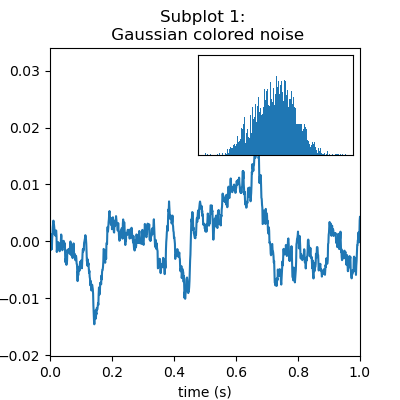

In [37]:
# https://matplotlib.org/2.0.2/examples/pylab_examples/axes_demo.html

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# create some data to use for the plot
dt = 0.001
t = np.arange(0.0, 10.0, dt)
r = np.exp(-t[:1000]/0.05)               # impulse response
x = np.random.randn(len(t))
s = np.convolve(x, r)[:len(x)]*dt  # colored noise

fig = plt.figure(figsize=(4, 4),facecolor='white')
ax = fig.add_subplot(111)
# the main axes is subplot(111) by default
plt.plot(t, s)
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Subplot 1: \n Gaussian colored noise')

# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="50%", # width = 30% of parent_bbox
                    height=1.0, # height : 1 inch
                    loc=1)
n, bins, patches = plt.hist(s, 400)
#plt.title('Probability')
plt.xticks([])
plt.yticks([])

#plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


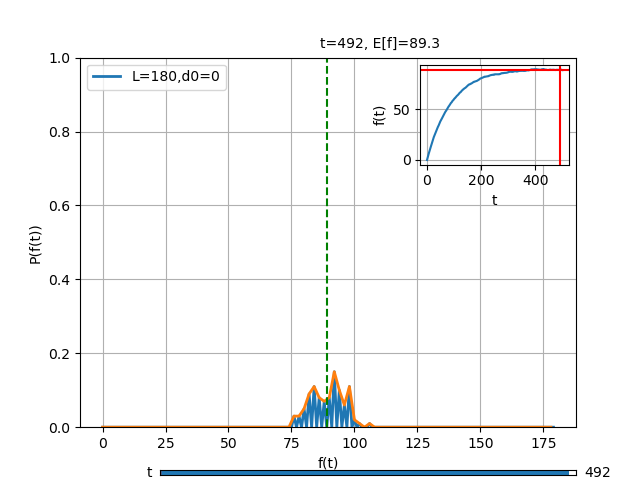

In [66]:
#https://stackoverflow.com/questions/7153969/matplotlib-slider-redraw-does-not-update-figtext

data1 = P_t
data2 = P_even
data3 = Means

import numpy as np
import pylab as p
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
p.grid()
ax.set_ylim(0,1)
#x = np.arange(0,500,1)
#f = np.sin(x/100.0)
#l11, = p.plot(f)

t = 0
l11, = p.plot([i for i in range(len(data1[t]))], data1[t], lw=2,label ="L=180,d0=0")
l12, = p.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
#l2, = p.scatter(Final[t,0],0.5, lw=2)

line = p.axvline(x=data3[t,0],linestyle="--",color="green")
ax.legend(loc="upper left")
ax.set_ylabel('P(f(t))', fontsize=10)
ax.set_xlabel('f(t)', fontsize=10)

#ax = p.axes([0.25, 0.05, 0.7, 0.03])#, axisbg='lightgoldenrodyellow')


axs = p.axes([0.25, 0.01, 0.65, 0.01])
slider1 = Slider(axs, 't', 0, 500, valinit=0)

# the text on the figure
fig_text = p.figtext(0.5, 0.9,  str(slider1.val))

def F(t,array):
    return array[t]

def update(val):

    value = int(slider1.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])

    fig_text.set_text("t="+str(value)+", E[f]="+str(data3[value,0]))

    p.draw()
    
from mpl_toolkits.axes_grid.inset_locator import inset_axes
# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="30%", # width = 30% of parent_bbox
                    height=1.0, # height : 1 inch
                    loc=1)
#n, bins, patches = plt.hist(s, 400)
plt.plot([i for i in range(len(data3[:,0]))],data3[:,0])
line2 = plt.axvline(x=t,linestyle="-",color="red")
line3 = plt.axhline(y=data3[t,0],linestyle="-",color="red")
plt.ylabel('f(t)', fontsize=10)
plt.xlabel('t', fontsize=10)
plt.grid()

slider1.on_changed(update)
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Different Example

In [68]:
N = 15
repeat_num = 100

G0 = create_data(N)
Edge = len(G0.copy().edges())

print(Edge)

d_initial = 0#int(Edge/2)

Gs = Create_Initial_Graphs(repeat_num,N,d_initial)

data = Quench_Process(Gs)

P_t,P_even = Get_Probabilites(data,Edge,repeat_num)

Means  = Get_Means(data)

  0%|          | 0/100 [00:00<?, ?it/s]

420


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [113]:
from sympy import *
f0 = 0

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

sol = gsol.subs({L: 420,d:0})
lmbd_sol = lambdify(t, sol.rhs)

<IPython.core.display.Javascript object>


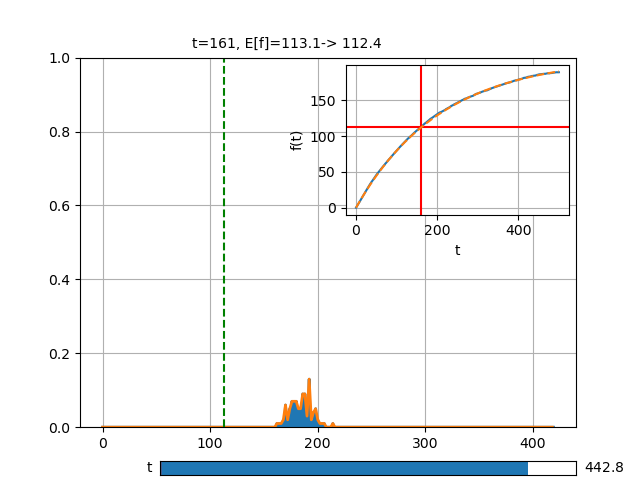

In [112]:
#https://stackoverflow.com/questions/7153969/matplotlib-slider-redraw-does-not-update-figtext

data1 = P_t
data2 = P_even
data3 = Means

import numpy as np
import pylab as p
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
p.grid()
ax.set_ylim(0,1)
#x = np.arange(0,500,1)
#f = np.sin(x/100.0)
#l11, = p.plot(f)

t = 0
l11, = p.plot([i for i in range(len(data1[t]))], data1[t], lw=2,label ="L=420,d0=0")
l12, = p.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
#l2, = p.scatter(Final[t,0],0.5, lw=2)

line = p.axvline(x=data3[t,0],linestyle="--",color="green")
ax.legend(loc="upper right")
#ax = p.axes([0.25, 0.05, 0.7, 0.03])#, axisbg='lightgoldenrodyellow')


axs = p.axes([0.25, 0.01, 0.65, 0.03])
slider1 = Slider(axs, 't', 0, 500, valinit=0)

# the text on the figure
fig_text = p.figtext(0.3, 0.9,  str(slider1.val))

def F(t,array):
    return array[t]

def update(val):

    value = int(slider1.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])

    fig_text.set_text("t="+str(value)+", E[f]="+str(data3[value,0])+"-> "+str(np.round(lmbd_sol(value),2)))

    p.draw()
    
from mpl_toolkits.axes_grid.inset_locator import inset_axes
# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="45%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=1)
#n, bins, patches = plt.hist(s, 400)
plt.plot([i for i in range(len(data3[:,0]))],data3[:,0])
line2 = plt.axvline(x=t,linestyle="-",color="red")
line3 = plt.axhline(y=data3[t,0],linestyle="-",color="red")
plt.ylabel('f(t)', fontsize=10)
plt.xlabel('t', fontsize=10)

######################

xs = np.linspace(0,500,1000)
plt.plot(xs,lmbd_sol(xs),linestyle="--")
plt.grid()
plt.show()

slider1.on_changed(update)
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [117]:
N = 5
repeat_num = 100

G0 = create_data(N)
Edge = len(G0.copy().edges())

print(Edge)

d_initial = int(Edge/2)

print(d_initial)

Gs = Create_Initial_Graphs(repeat_num,N,d_initial)

print(len(Gs))

data = Quench_Process(Gs)

P_t,P_even = Get_Probabilites(data,Edge,repeat_num)

Means  = Get_Means(data)

  0%|          | 0/100 [00:00<?, ?it/s]

40
20


  1%|          | 1/100 [00:00<00:11,  8.81it/s]

100


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


In [119]:
f_avg = []
for g in Gs:
    print("d=",calculate_delta(g),",f=",frustration_count(g))
    
    f_avg.append(frustration_count(g))

print(np.mean(f_avg))

d= 20 ,f= 24
d= 20 ,f= 22
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 22
d= 20 ,f= 24
d= 20 ,f= 22
d= 20 ,f= 20
d= 20 ,f= 20
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 28
d= 20 ,f= 24
d= 20 ,f= 20
d= 20 ,f= 22
d= 20 ,f= 22
d= 20 ,f= 28
d= 20 ,f= 28
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 22
d= 20 ,f= 24
d= 20 ,f= 28
d= 20 ,f= 20
d= 20 ,f= 28
d= 20 ,f= 22
d= 20 ,f= 20
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 20
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 22
d= 20 ,f= 22
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 30
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 22
d= 20 ,f= 20
d= 20 ,f= 26
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 26
d= 20 ,f= 20
d= 20 ,f= 24
d= 20 ,f= 24
d= 20 ,f= 24
d= 20 ,f= 22
d= 20 ,f= 30
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 24
d= 20 ,f= 24
d= 20 ,f= 26
d= 20 ,f= 26
d= 20 ,f= 22
d= 20 ,f= 24

In [122]:
from sympy import *
f0 = 24.06

t = symbols('t')
x = symbols('x', cls=Function)
L = symbols('L', real=True)
d = symbols('d', real=True)

gsol = dsolve(x(t).diff(t) - ((1 - 2*L)*x(t) + L*(L - 1) + d**2)/(L*(L - 1)), x(t),ics={x(0): f0})

sol = gsol.subs({L: 40,d:20})
lmbd_sol = lambdify(t, sol.rhs)

<IPython.core.display.Javascript object>


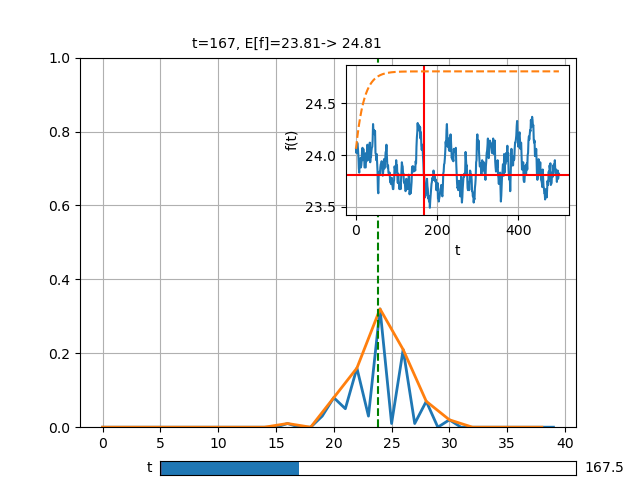

In [123]:
#https://stackoverflow.com/questions/7153969/matplotlib-slider-redraw-does-not-update-figtext

data1 = P_t
data2 = P_even
data3 = Means

import numpy as np
import pylab as p
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
p.grid()
ax.set_ylim(0,1)
#x = np.arange(0,500,1)
#f = np.sin(x/100.0)
#l11, = p.plot(f)

t = 0
l11, = p.plot([i for i in range(len(data1[t]))], data1[t], lw=2,label ="L=420,d0=0")
l12, = p.plot([i*2 for i in range(len(data2[t]))], data2[t], lw=2)
#l2, = p.scatter(Final[t,0],0.5, lw=2)

line = p.axvline(x=data3[t,0],linestyle="--",color="green")
ax.legend(loc="upper right")
#ax = p.axes([0.25, 0.05, 0.7, 0.03])#, axisbg='lightgoldenrodyellow')


axs = p.axes([0.25, 0.01, 0.65, 0.03])
slider1 = Slider(axs, 't', 0, 500, valinit=0)

# the text on the figure
fig_text = p.figtext(0.3, 0.9,  str(slider1.val))

def F(t,array):
    return array[t]

def update(val):

    value = int(slider1.val)

    l11.set_ydata(data1[value])
    l12.set_ydata(data2[value])
    line.set_xdata(data3[value,0])
    line2.set_xdata(value)
    line3.set_ydata(data3[value,0])

    fig_text.set_text("t="+str(value)+", E[f]="+str(data3[value,0])+"-> "+str(np.round(lmbd_sol(value),2)))

    p.draw()
    
from mpl_toolkits.axes_grid.inset_locator import inset_axes
# this is an inset axes over the main axes
inset_axes = inset_axes(ax, 
                    width="45%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=1)
#n, bins, patches = plt.hist(s, 400)
plt.plot([i for i in range(len(data3[:,0]))],data3[:,0])
line2 = plt.axvline(x=t,linestyle="-",color="red")
line3 = plt.axhline(y=data3[t,0],linestyle="-",color="red")
plt.ylabel('f(t)', fontsize=10)
plt.xlabel('t', fontsize=10)

######################

xs = np.linspace(0,500,1000)
plt.plot(xs,lmbd_sol(xs),linestyle="--")
plt.grid()
plt.show()

slider1.on_changed(update)
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Checking Delta

In [136]:
def Create_Initial_Graphs_check_delta(repeat_num,N,delta = 0):

    Gs = []
    d_target = delta
    
    print("Target=",d_target)
    
    for i in tqdm(range(repeat_num)):

        G0 = create_data(N)
        edge = len(G0.copy().edges())
        H = G0.copy() 
        
        print("Before loop",calculate_delta(H), frustration_count(H))

        #while (calculate_delta(H) != d_target):
        while ((calculate_delta(H) != d_target and frustration_count(H) != d_target)):

            H = simulated_annealing(G0.copy(),target=d_target)

        print("\tFinal, d=",calculate_delta(H),",f=",frustration_count(H))
        Gs.append(H.copy())
        
    return Gs

In [137]:
def Quench_Process_check_delta(Gs):

    total=[]
    Delta = []
    for i in tqdm(range(100)):
        
        H = Gs[i].copy()
        
        res=[]
        res.append(frustration_count(H))
        deltas = []
        deltas.append(calculate_delta(H))
        for k in range(0,499):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            
            fr = frustration_count(H)
            res.append(fr)
            deltas.append(calculate_delta(H))

        total.append(res) 
        Delta.append(deltas)
        
    return np.array(total),np.array(Delta)

In [138]:
N = 5
repeat_num = 100

G0 = create_data(N)
Edge = len(G0.copy().edges())

print(Edge)

d_initial = int(Edge/2)

Gs = Create_Initial_Graphs_check_delta(repeat_num,N,d_initial)

data,Deltas = Quench_Process_check_delta(Gs)

P_t,P_even = Get_Probabilites(data,Edge,repeat_num)

Means  = Get_Means(data)

  0%|          | 0/100 [00:00<?, ?it/s]

40
Target= 20
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


  3%|▎         | 3/100 [00:00<00:20,  4.65it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


  4%|▍         | 4/100 [00:00<00:19,  4.86it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0


  6%|▌         | 6/100 [00:01<00:16,  5.61it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


  8%|▊         | 8/100 [00:01<00:16,  5.43it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 26


  9%|▉         | 9/100 [00:01<00:14,  6.20it/s]

Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 11%|█         | 11/100 [00:02<00:23,  3.71it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 13%|█▎        | 13/100 [00:02<00:17,  5.02it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24


 15%|█▌        | 15/100 [00:02<00:14,  5.90it/s]

Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


 17%|█▋        | 17/100 [00:03<00:12,  6.72it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 20


 19%|█▉        | 19/100 [00:03<00:10,  7.83it/s]

Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 20%|██        | 20/100 [00:03<00:12,  6.61it/s]

	Final, d= 20 ,f= 28
Before loop 0 0


 21%|██        | 21/100 [00:03<00:13,  5.95it/s]

	Final, d= 20 ,f= 26
Before loop 0 0


 23%|██▎       | 23/100 [00:04<00:16,  4.62it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 24


 24%|██▍       | 24/100 [00:04<00:14,  5.41it/s]

Before loop 0 0
	Final, d= 20 ,f= 28
Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 26%|██▌       | 26/100 [00:04<00:12,  5.85it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 27%|██▋       | 27/100 [00:04<00:15,  4.67it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 28%|██▊       | 28/100 [00:05<00:16,  4.46it/s]

	Final, d= 20 ,f= 26
Before loop 0 0


 29%|██▉       | 29/100 [00:05<00:16,  4.23it/s]

	Final, d= 20 ,f= 20
Before loop 0 0


 31%|███       | 31/100 [00:05<00:14,  4.75it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 32%|███▏      | 32/100 [00:05<00:12,  5.59it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 34%|███▍      | 34/100 [00:06<00:11,  5.60it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 20


 36%|███▌      | 36/100 [00:06<00:09,  6.71it/s]

Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 39%|███▉      | 39/100 [00:07<00:12,  4.87it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 24


 40%|████      | 40/100 [00:07<00:12,  4.64it/s]

Before loop 0 0
	Final, d= 20 ,f= 28
Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0


 42%|████▏     | 42/100 [00:07<00:11,  4.98it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0


 44%|████▍     | 44/100 [00:07<00:09,  5.73it/s]

	Final, d= 20 ,f= 22
Before loop 0 0


 47%|████▋     | 47/100 [00:08<00:09,  5.84it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 20


 48%|████▊     | 48/100 [00:08<00:08,  5.86it/s]

Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 50%|█████     | 50/100 [00:08<00:09,  5.36it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


 52%|█████▏    | 52/100 [00:09<00:10,  4.76it/s]

	Final, d= 20 ,f= 28
Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 54%|█████▍    | 54/100 [00:09<00:09,  4.73it/s]

	Final, d= 20 ,f= 20
Before loop 0 0
	Final, d= 20 ,f= 28


 55%|█████▌    | 55/100 [00:10<00:08,  5.00it/s]

Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 56%|█████▌    | 56/100 [00:10<00:09,  4.61it/s]

	Final, d= 20 ,f= 22
Before loop 0 0


 57%|█████▋    | 57/100 [00:10<00:10,  4.15it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 59%|█████▉    | 59/100 [00:11<00:11,  3.59it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 62%|██████▏   | 62/100 [00:11<00:08,  4.42it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 64%|██████▍   | 64/100 [00:12<00:09,  4.00it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


 65%|██████▌   | 65/100 [00:12<00:07,  4.64it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 68%|██████▊   | 68/100 [00:13<00:08,  3.87it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 20


 69%|██████▉   | 69/100 [00:13<00:06,  4.52it/s]

Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 70%|███████   | 70/100 [00:13<00:07,  4.15it/s]

	Final, d= 20 ,f= 26
Before loop 0 0


 71%|███████   | 71/100 [00:14<00:07,  3.79it/s]

	Final, d= 20 ,f= 24
Before loop 0 0


 73%|███████▎  | 73/100 [00:14<00:06,  4.11it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 75%|███████▌  | 75/100 [00:15<00:05,  4.21it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 26
Before loop 0 0


 76%|███████▌  | 76/100 [00:15<00:05,  4.79it/s]

	Final, d= 20 ,f= 28
Before loop 0 0


 78%|███████▊  | 78/100 [00:15<00:04,  5.27it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 80%|████████  | 80/100 [00:15<00:03,  6.57it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 81%|████████  | 81/100 [00:16<00:03,  6.29it/s]

	Final, d= 20 ,f= 26
Before loop 0 0


 83%|████████▎ | 83/100 [00:16<00:03,  5.49it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 85%|████████▌ | 85/100 [00:17<00:03,  3.81it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22


 86%|████████▌ | 86/100 [00:17<00:03,  4.27it/s]

Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0


 89%|████████▉ | 89/100 [00:18<00:02,  4.96it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 22


 91%|█████████ | 91/100 [00:18<00:01,  6.02it/s]

Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 93%|█████████▎| 93/100 [00:18<00:01,  5.62it/s]

	Final, d= 20 ,f= 22
Before loop 0 0
	Final, d= 20 ,f= 20
Before loop 0 0


 95%|█████████▌| 95/100 [00:18<00:00,  5.79it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 24
Before loop 0 0


 97%|█████████▋| 97/100 [00:19<00:00,  6.57it/s]

	Final, d= 20 ,f= 26
Before loop 0 0
	Final, d= 20 ,f= 22
Before loop 0 0


 98%|█████████▊| 98/100 [00:19<00:00,  6.64it/s]

	Final, d= 20 ,f= 22
Before loop 0 0


  0%|          | 0/100 [00:00<?, ?it/s]

	Final, d= 20 ,f= 24
Before loop 0 0
	Final, d= 20 ,f= 22


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


<IPython.core.display.Javascript object>


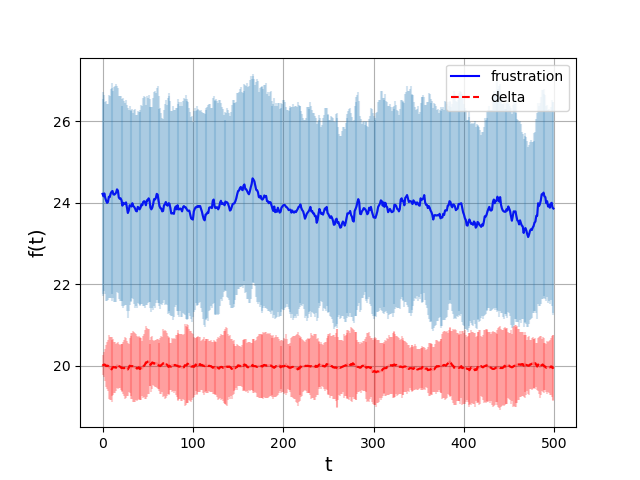

In [181]:
d_avg = []
for i in range(500):
    d_avg.append((np.mean(Deltas[:,i]),np.std(Deltas[:,i])))
    
D_avg = np.array(d_avg)

fig, ax = plt.subplots()

ax.errorbar([i for i in range(500)],Means[:,0],Means[:,1],alpha=0.2)
ax.plot([i for i in range(500)],Means[:,0],color="blue",label="frustration")

ax.errorbar([i for i in range(500)],D_avg[:,0],D_avg[:,1],alpha=0.2,color="red")
ax.plot([i for i in range(500)],D_avg[:,0],color="red",label="delta",linestyle="--")

ax.legend(loc="upper right")
plt.xlabel('t', fontsize=14)
plt.ylabel('f(t)', fontsize=14)
plt.grid()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Theory - Master Equation

In [62]:
def k1(L,d,x):

    return (4*x**2 - d**2)/(2*L*(L-1))

def k2(L,d,x):

    return (4*x**2 + (1-2*L)*2*x + L*(L-1))/(2*L*(L-1))

def master_equation(prob, L,d, k1, k2, dt):

    num_boxes, time_points = np.shape(prob)
     
    for t in range(1, time_points): 

        prob[0, t] = prob[0, t-1] + k1(L,d,1) * dt * prob[1, t-1] - k2(L,d,0) * dt * prob[0, t-1]
       
        last_box = num_boxes - 1
        prob[last_box, t] = prob[last_box, t-1] + \
                                k1(L,d,last_box-1) * dt * prob[last_box-1, t-1] -\
                                k2(L,d,last_box) * dt * prob[last_box, t-1]
                
        for box in range(1, num_boxes - 1):
            prob[box, t] = prob[box, t-1] +\
                            k1(L,d,box-1) * dt * prob[box-1, t-1] +\
                            k2(L,d,box+1) * dt * prob[box+1, t-1] -\
                            (k1(L,d,box)+k2(L,d,box)) * dt * prob[box, t-1]
            
            if prob[box, t] > 1:
                print(box,t,prob[box, t])

    return prob

In [63]:
def Calculate_Probability_from_Master_equation(l,delta,d0):
    
    print(l,delta,d0)
    
    d = delta
    L = int(l/2)
    
    dt = 1 / 50
    num_boxes = L
    time_steps = 500

    import numpy as np
    
    prob = np.zeros((num_boxes, time_steps))

    print(np.shape(prob))
    initial_position = d0 #int(num_boxes/ 2) - 1
    
    prob[initial_position, 0] = 1.0

    prob = master_equation(prob, L, d, k1 , k2, dt)
    
    return prob

In [64]:
L = 40

delta = 0

d0 = int(L/4)

prob = Calculate_Probability_from_Master_equation(L,delta,d0)

40 0 10
(20, 500)


<IPython.core.display.Javascript object>


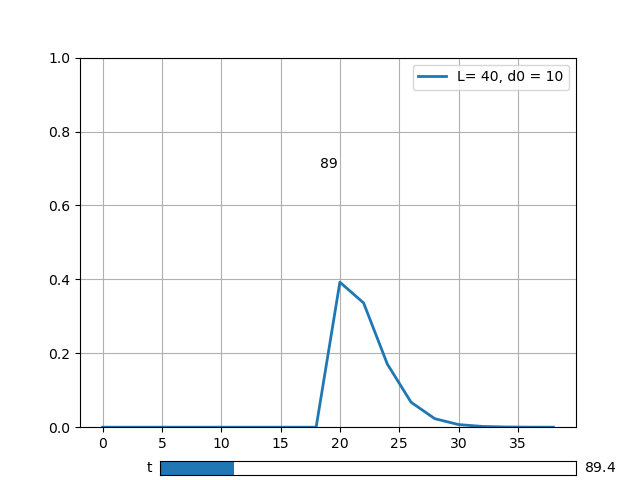

In [65]:
#https://stackoverflow.com/questions/7153969/matplotlib-slider-redraw-does-not-update-figtext

import numpy as np
import pylab as p
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
p.grid()
ax.set_ylim(0,1)
#l11, = p.plot(f)

t = 0
l10, = p.plot([i*2 for i in range(len(prob[:,t]))], prob[:,t], lw=2,label ="L= "+str(L)+", d0 = "+str(d0))
#l12, = p.plot([i*2 for i in range(len(Prob[:,t]))], Prob[:,t], lw=2)
#l2, = p.scatter(Final[t,0],0.5, lw=2)

#line = p.axvline(x=Final[t,0],linestyle="--",color="green")
ax.legend(loc="upper right")
#ax = p.axes([0.25, 0.05, 0.7, 0.03])#, axisbg='lightgoldenrodyellow')


ax = p.axes([0.25, 0.01, 0.65, 0.03])
slider1 = Slider(ax, 't', 0, 500, valinit=0)

# the text on the figure
fig_text = p.figtext(0.5, 0.65,  str(slider1.val))

def F(t,array):
    return array[t]

def update(val):
    
    value = int(slider1.val)
    
    #f = slider1.val*np.sin(x/100.0)
    
    #l11.set_xdata([i*2 for i in range(len(P_even[value]))])
    l10.set_ydata(prob[:,value])

    
    #l12.set_ydata(P_even[value])
    #line.set_xdata(Final[value,0])
    #np.set_printoptions(precision=2)

    # update the value of the Text object
    fig_text.set_text(str(value))#+" "+str(Final[value,0]))#+str(F(value,Final[:,0])))#str(slider1.val))

    p.draw()

slider1.on_changed(update)
p.show()